In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [1]:
# Import customs module to tokenize and clean tweet dataset
from clean_tokenizer import tokenize_tweets
data_dir = '../input/health_tweets.csv'
tweets_df = tokenize_tweets(data_dir)

Complete. Number of Tweets that have been cleaned and tokenized : 189778


In [2]:
tweets_df.head()

,id,date,timezone,tweet,hashtags,username,name,day,hour,retweet,nlikes,nreplies,nretweets,clean_tweets
0,1243691997111648259,2020-03-28 00:10:53,UTC,How the UK’s coronavirus epidemic compares to ...,[],bbchealth,BBC Health News,2,13,False,20,4,9,coronavirus epidemic compare countries
1,1243595351522791424,2020-03-27 17:46:51,UTC,Health workers on frontline to be tested in En...,[],bbchealth,BBC Health News,1,20,False,34,5,15,health workers frontline test england
2,1243418020740886533,2020-03-27 06:02:12,UTC,Coronavirus: Protective gear guidance 'to be u...,[],bbchealth,BBC Health News,2,12,False,24,4,15,coronavirus protective gear guidance update
3,1243357973012869121,2020-03-27 02:03:35,UTC,Coronavirus: What are ventilators and why are ...,[],bbchealth,BBC Health News,4,19,False,30,1,24,coronavirus ventilators important
4,1243266112135069707,2020-03-26 19:58:34,UTC,Coronavirus: 'Act early to save more than 30 m...,[],bbchealth,BBC Health News,3,8,False,6,0,3,coronavirus early save million live


In [11]:
# create df of handle and tweet only to easily see how tweet is originally formatted
simple_df  = tweets_df[['username', 'tweet']]
simple_df.head() 

,username,tweet
0,bbchealth,How the UK’s coronavirus epidemic compares to ...
1,bbchealth,Health workers on frontline to be tested in En...
2,bbchealth,Coronavirus: Protective gear guidance 'to be u...
3,bbchealth,Coronavirus: What are ventilators and why are ...
4,bbchealth,Coronavirus: 'Act early to save more than 30 m...


### Average words per tweet across news sources (excluding stop words)

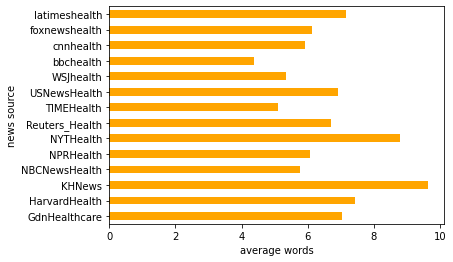

In [12]:
# Create column for number of words in tweet
tweets_df['nwords'] =  tweets_df['clean_tweets'].str.split().str.len()

# Plot avg word count per Twitter handle
tweets_df.groupby('username')['nwords'].mean().plot(kind='barh', color='orange')
plt.xlabel('average words')
plt.ylabel('news source')
plt.show()

### Word Cloud of Tokens

In [13]:
from wordcloud import WordCloud, STOPWORDS

# String together cleaned tokens from tweets
words_list = ' '.join(tweets_df['clean_tweets']) 
stopwords = set(STOPWORDS)

# Word cloud configuration
wordcloud = WordCloud(width = 800, height = 800,
                     background_color = 'white',
                     stopwords = stopwords,
                     min_font_size = 10).generate(words_list)

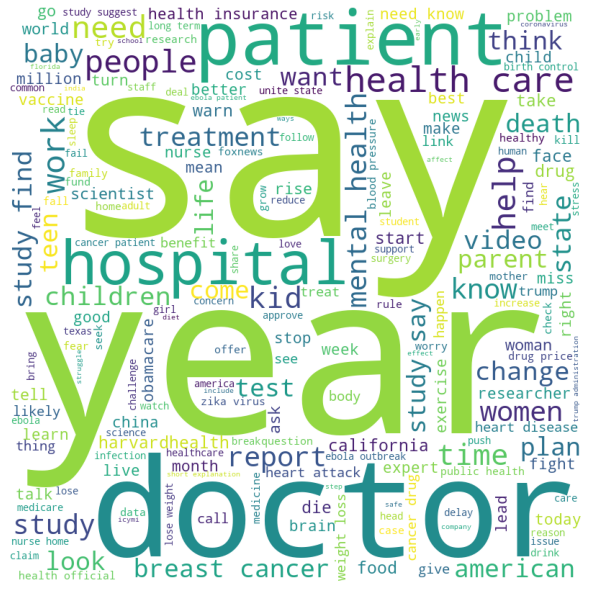

In [14]:
# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Counts of Bigrams

In [23]:
def find_bigrams(tweet, bigrams=True):   # master function to clean tweet
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    
    tweet_token_list = lemmatize(tweet)  # apply lemmatization and tokenization

    if bigrams:
        tweet_token_list = [tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    #tweet_token_list + (taken from above assignment)
    tweet_token_list= ' '.join(tweet_token_list)
    return tweet_token_list

In [24]:
bigrams = simple_df.tweet.apply(find_bigrams).to_frame()

In [25]:
#check bigram example
print((bigrams.iloc[0,0]))

coronavirus_epidemic epidemic_compare compare_countries


In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=500, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(bigrams['tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
bigram_names = vectorizer.get_feature_names()


In [27]:
#Convert tf to a dataframe, assign columns to bigram names, and calculate total
tf = pd.DataFrame(tf)
tf.columns = [bigram_names]
sample_tf = tf.head()
tf.loc['total',:] = tf.sum(axis=0)
tf.loc['total']

blood_pressure       664.0
breast_cancer       1308.0
cancer_drug          720.0
drug_price           609.0
health_care         2761.0
health_insurance     752.0
health_officials     544.0
heart_attack         680.0
heart_disease        738.0
long_term            522.0
mental_health       1759.0
need_know            756.0
nurse_home           526.0
public_health        667.0
study_find          1471.0
study_say           1349.0
study_suggest        552.0
unite_state          525.0
weight_loss          711.0
zika_virus           598.0
Name: total, dtype: float64

Text(0, 0.5, 'Bigrams')

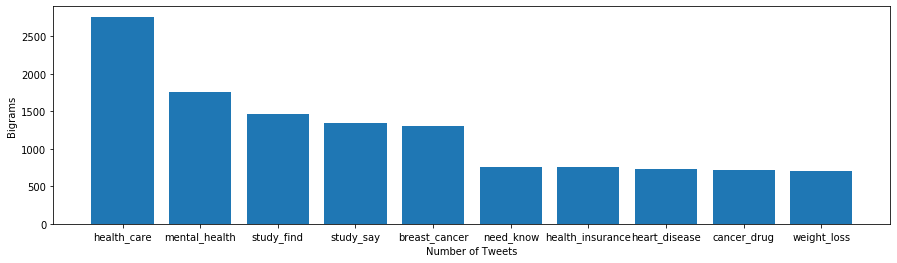

In [28]:
topicslist = pd.DataFrame(data = tf.loc['total'])
topicslist = topicslist.reset_index()
topicslist = topicslist.rename(columns = {"level_0":"bigrams"})
topicslist = topicslist.sort_values(by = ['total'], ascending = False)
topicslist_10 = topicslist[:10]

topicslist_10['bigrams']
fig = plt.figure()
fig.set_figwidth(15)
plt.bar(topicslist_10['bigrams'], topicslist_10['total'])
plt.xlabel('Number of Tweets')
plt.ylabel('Bigrams')
